## Simulate and fit DCE-MRI

In [5]:
import sys
sys.path.append('..\\src')
sys.path.append('..\\..\\DCE-DSC-MRI_CodeCollection\\src')
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
import matplotlib.pyplot as plt
import numpy as np

---
### Concentration-time data

parameter: value (ground truth)
vp: 0.010031 (0.010000)
ps: 0.005007 (0.005000)
ve: 0.189140 (0.200000)
fp: 29.896354 (30.000000)


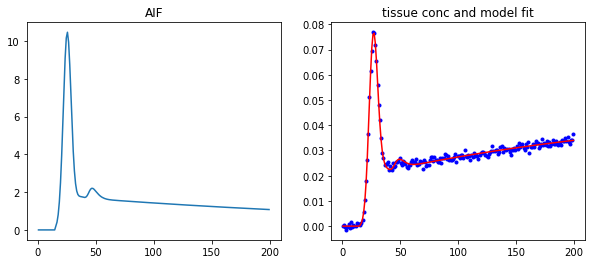

In [7]:
from dce import aifs, pk_models, dce_fit

# define timepoints
dt = 1.
t = np.arange(0,200)*dt + dt/2

# define AIF, pharmacokinetic model and noise level
aif = aifs.parker(hct=0.42, t_start=15.)
pk_pars = {'vp': 0.01, 'ps': 5e-3, 've': 0.2, 'fp': 30, 'ktrans': 5e-2}
pk_model = pk_models.tcxm(t, aif) # <-- CHANGE THE MODEL HERE
noise = 0.001

# generate "measured" concentration with noise
c_t, _c_cp, _c_e = pk_model.conc(**pk_pars)
c_t += np.random.normal(loc = 0., scale = noise, size = c_t.shape)

# fit measured concentration using the same pharmacokinetic model
pk_pars_0 = [{'vp': 0.1, 'ps': 5e-3, 've': 0.3, 'fp': 20, 'ktrans': 1e-4},
                         {'vp': 0.1, 'ps': 5e-3, 've': 0.3, 'fp': 20, 'ktrans': 1e-4}]
pk_pars_fit, c_t_fit = dce_fit.conc_to_pkp(c_t, pk_model, pk_pars_0)

print("parameter: value (ground truth)")
[ print(f"{key}: {val:.6f} ({pk_pars[key]:.6f})") for key, val in pk_pars_fit.items() ]

fig, ax = plt.subplots(1,2, figsize=(10,4))
ax[0].plot(t, aif.c_ap(t));
ax[0].set_title('AIF');
ax[1].plot(t, c_t, 'b.', t, c_t_fit, 'r-');
ax[1].set_title('tissue conc and model fit');

---
### Signal-time data

parameter: value (ground truth)
vp: 0.010008 (0.010000)
ps: 0.005055 (0.005000)
ve: 0.159651 (0.200000)
fp: 30.301731 (30.000000)


Text(0.5, 1.0, 'enhancement and fit')

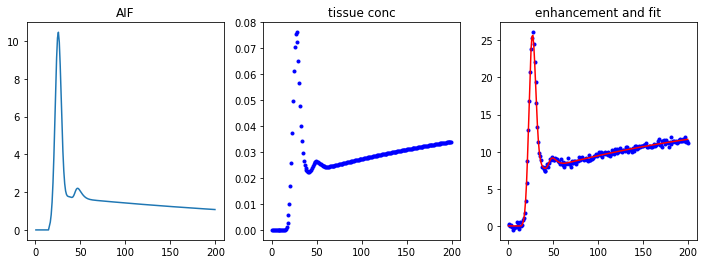

In [10]:
from dce import aifs, pk_models, dce_fit, relaxivity, signal_models, water_ex_models

# define timepoints
dt = 1.
t = np.arange(0,200)*dt + dt/2

# define AIF, pharmacokinetic model and noise level
aif = aifs.parker(hct=0.42, t_start=15.)
pk_pars = {'vp': 0.01, 'ps': 5e-3, 've': 0.2, 'fp': 30, 'ktrans': 5e-2}
pk_model = pk_models.tcxm(t, aif) # <-- CHANGE THE MODEL HERE

R10_tissue = 1./0.8
R10_vif = 1./1.7
k_vif, k_tissue = 1., 1.
hct = 0.42
tr, fa_rad, te = 4e-3, 15.*(np.pi/180.), 1.5e-3

# processing options
baseline_idx = [0,1,2]
c_to_r_model = relaxivity.c_to_r_linear(r1=5.0, r2 = 0)
signal_model = signal_models.spgr(tr, fa_rad, te)
water_ex_model = water_ex_models.fxl()


noise = 0.25

# generate enhancement with noise
c_t, _c_cp, _c_e = pk_model.conc(**pk_pars)
enh = dce_fit.pkp_to_enh(pk_pars, hct, k_tissue, R10_tissue, R10_vif, pk_model, c_to_r_model, water_ex_model, signal_model)
enh += np.random.normal(loc = 0., scale = noise, size = enh.shape)

# fit measured concentration using the same pharmacokinetic model
pk_pars_0 = [{'vp': 0.1, 'ps': 5e-3, 've': 0.3, 'fp': 20, 'ktrans': 1e-4},
                         {'vp': 0.1, 'ps': 5e-3, 've': 0.3, 'fp': 20, 'ktrans': 1e-4}]
pk_pars_fit, enh_fit = dce_fit.enh_to_pkp(enh, hct, k_tissue, R10_tissue, R10_vif, pk_model, c_to_r_model, water_ex_model, signal_model)

print("parameter: value (ground truth)")
[ print(f"{key}: {val:.6f} ({pk_pars[key]:.6f})") for key, val in pk_pars_fit.items() ]

fig, ax = plt.subplots(1,3, figsize=(12,4))
ax[0].plot(t, aif.c_ap(t));
ax[0].set_title('AIF');
ax[1].plot(t, c_t, 'b.');
ax[1].set_title('tissue conc');
ax[2].plot(t, enh, 'b.', t, enh_fit, 'r-')
ax[2].set_title('enhancement and fit')